In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_parquet('./IDS2017/Final/DDoS_Attacks.parquet')
print(data.columns)
display(data.head())

# Drop the label column to focus on unsupervised learning
X = data.drop(' Label', axis=1)

# Display the first few rows of the data
display(X.head())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Building the autoencoder
input_dim = X_train.shape[1]
encoding_dim = 14  # Number of neurons in the bottleneck layer, adjust as necessary
hidden_dim = 14  # Number of neurons in the hidden layer, adjust as necessary

autoencoder = Sequential()
autoencoder.add(Dense(hidden_dim, activation='relu', input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dense(hidden_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training the autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_test, X_test))

# Predictions
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Calculating the mean squared error for train and test predictions
train_mse = mean_squared_error(X_train, X_train_pred)
test_mse = mean_squared_error(X_test, X_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


Index([' Label', ' Destination Port', 'Total Length of Fwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Mean',
       ' Fwd Header Length', ' Avg Fwd Segment Size', ' Subflow Fwd Bytes',
       'Init_Win_bytes_forward', ' act_data_pkt_fwd'],
      dtype='object')


,Label,Destination Port,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Header Length,Avg Fwd Segment Size,Subflow Fwd Bytes,Init_Win_bytes_forward,act_data_pkt_fwd
0,BENIGN,54865,12,6,6.0,40,6.0,12,33,1
1,BENIGN,55054,6,6,6.0,20,6.0,6,29,0
2,BENIGN,55055,6,6,6.0,20,6.0,6,29,0
3,BENIGN,46236,6,6,6.0,20,6.0,6,31,0
4,BENIGN,54863,12,6,6.0,40,6.0,12,32,1


,Destination Port,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Header Length,Avg Fwd Segment Size,Subflow Fwd Bytes,Init_Win_bytes_forward,act_data_pkt_fwd
0,54865,12,6,6.0,40,6.0,12,33,1
1,55054,6,6,6.0,20,6.0,6,29,0
2,55055,6,6,6.0,20,6.0,6,29,0
3,46236,6,6,6.0,20,6.0,6,31,0
4,54863,12,6,6.0,40,6.0,12,32,1


c:\Users\pegie\repos\ids2017-anomaly-detection\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


KeyboardInterrupt: 

Training MSE: 0.7436321884013158
Test MSE: 0.8888026179384608


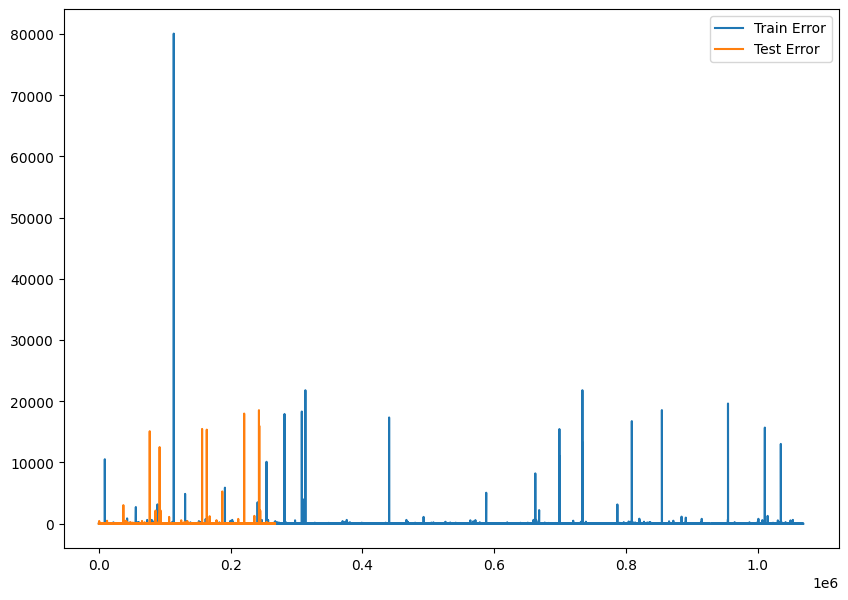

Number of anomalies detected: 26811


In [25]:
# Calculate reconstruction error
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
print(f"Training MSE: {np.mean(mse_train)}")
print(f"Test MSE: {np.mean(mse_test)}")
# Anomaly detection
threshold = np.percentile(mse_train, 90)  # You can adjust the threshold

# Identifying anomalies
anomalies = mse_test > threshold

plt.figure(figsize=(10, 7))
plt.plot(mse_train, label='Train Error')
plt.plot(mse_test, label='Test Error')
plt.legend()
plt.show()

print(f"Number of anomalies detected: {np.sum(anomalies)}")

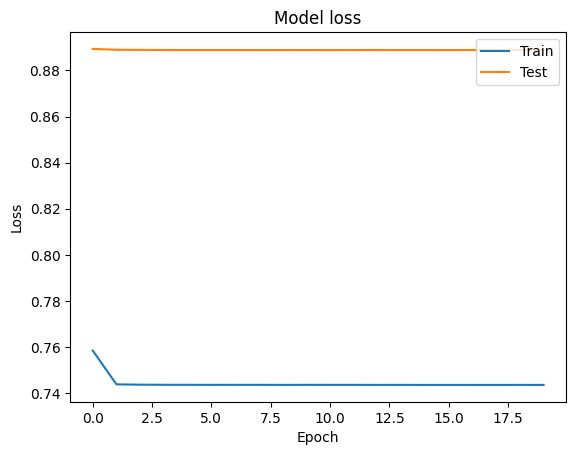

In [26]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()